In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# --------- Parameter Settings ---------
content_img_path = "E:/CV/content.jpg"  # Replace with your own path
style_img_path = "E:/CV/style.jpg"      # Replace with your own path
output_img_path = "E:/CV/output.jpg"

# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved parameters for better quality
image_size = 512  # You can increase this for higher resolution (e.g., 1024)
num_steps = 300   # More steps for better convergence
tv_weight = 1e-6  # Total variation loss weight

# --------- Image Preprocessing ---------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    image = tensor.clone().detach().cpu()  # Move to CPU for PIL conversion
    image = image.squeeze(0)
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    image = image.clamp(0, 1)
    return transforms.ToPILImage()(image)

# Load images
content = load_image(content_img_path)
style = load_image(style_img_path)

# --------- Feature Extraction Network ---------
class VGGFeatures(nn.Module):
    def __init__(self):
        super(VGGFeatures, self).__init__()
        self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
        # Freeze VGG parameters
        for param in self.vgg.parameters():
            param.requires_grad_(False)
            
        self.layers = {'0': 'conv1_1', '5': 'conv2_1', 
               '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'}
    
    def forward(self, x):
        features = {}
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.layers:
                features[self.layers[name]] = x
        return features

# --------- Gram Matrix Computation ---------
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G.div(b * c * h * w)

# --------- Initialization ---------
model = VGGFeatures().to(device)

# Initialize with content image for faster convergence
target = content.clone().requires_grad_(True).to(device)

# Use LBFGS optimizer for better results
optimizer = optim.LBFGS([target])

style_features = model(style)
content_features = model(content)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Style and content weights
style_weights = {
    'conv1_1': 0.75,  # More weight on lower layers for fine details
    'conv2_1': 0.5,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,   # Added deeper layer
}

content_weight = 1      
style_weight = 1e6      # Increased style weight for better stylization

# --------- Optimization Loop ---------
step = [0]  # Use a list to track step in closure
def closure():
    optimizer.zero_grad()
    target_features = model(target)
    
    # Content loss - only use one deeper layer
    content_loss = torch.mean((target_features['conv4_1'] - content_features['conv4_1'])**2)
    
    # Style loss
    style_loss = 0
    for layer in style_weights:
        if layer in target_features:  # Make sure layer exists
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss
    
    # Total variation loss for smoothness
    tv_loss = torch.sum(torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])) + \
              torch.sum(torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :]))
    
    total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss
    total_loss.backward()
    
    step[0] += 1
    if step[0] % 20 == 0:
        print(f"Step {step[0]}, Total loss: {total_loss.item():.2f}")
    
    return total_loss

# Run optimization with LBFGS
for i in range(num_steps // 10):  # LBFGS takes bigger steps
    optimizer.step(closure)
    
    # Save intermediate results
    if (i+1) % 5 == 0:
        with torch.no_grad():
            output_img = im_convert(target)
            output_img.save(f"E:/CV/output_step_{(i+1)*10}.jpg")

# --------- Save and Display Output ---------
output_img = im_convert(target)
output_img.save(output_img_path)

# Option to upscale the final image for better clarity
try:
    from PIL import Image
    final_img = Image.open(output_img_path)
    upscaled_img = final_img.resize((final_img.width*2, final_img.height*2), Image.LANCZOS)
    upscaled_img.save("E:/CV/output_upscaled.jpg")
    print("Created upscaled version at E:/CV/output_upscaled.jpg")
except Exception as e:
    print(f"Could not create upscaled version: {e}")

# Display the final image
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.title("Final Style Transfer Result")
plt.axis('off')
plt.show()

Using device: cpu
Step 20, Total loss: 16.94
Step 40, Total loss: 13.13
Step 60, Total loss: 12.02
Step 80, Total loss: 11.50
Step 100, Total loss: 11.18
Step 120, Total loss: 10.97
Step 140, Total loss: 10.82
Step 160, Total loss: 10.71
Step 180, Total loss: 10.63
Step 200, Total loss: 10.56
Step 220, Total loss: 10.50
Step 240, Total loss: 10.45
Step 260, Total loss: 10.41
Step 280, Total loss: 10.38
Step 300, Total loss: 10.35
Step 320, Total loss: 10.32
Step 340, Total loss: 10.30
Step 360, Total loss: 10.28
Step 380, Total loss: 10.26
Step 400, Total loss: 10.24
Step 420, Total loss: 10.22
Step 440, Total loss: 10.21
Step 460, Total loss: 10.20
Step 480, Total loss: 10.18
Step 500, Total loss: 10.17
Step 520, Total loss: 10.16
Step 540, Total loss: 10.15
Step 560, Total loss: 10.14
Step 580, Total loss: 10.14
Step 600, Total loss: 10.13
Created upscaled version at E:/CV/output_upscaled.jpg


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# --------- Settings ---------
content_img_path = "E:/CV/content.jpg"
style_img_path = "E:/CV/style.jpg"
output_img_path = "E:/CV/output.jpg"
device = torch.device("cpu")
image_size = 256
num_steps = 1000 
tv_weight = 1e-6

# --------- Preprocessing ---------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    image = tensor.clone().detach().squeeze(0)
    image = image * 0.5 + 0.5  # unnormalize
    image = image.clamp(0, 1)
    return transforms.ToPILImage()(image)

# --------- Modified CNN ---------
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=9, padding=4),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 32, kernel_size=1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Residual blocks
            self._residual_block(128),
            self._residual_block(128),
            self._residual_block(128),
            self._residual_block(128),
            self._residual_block(128),
            # Upsampling
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=9, padding=4),
            nn.Tanh()
        )

    def _residual_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.model(x) * 150 + 127.5

# --------- Gram Matrix ---------
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    G = torch.mm(features, features.t())
    return G / (b * c * h * w)

# --------- Load Images ---------
content = load_image(content_img_path)
style = load_image(style_img_path)

# --------- Extract Features ---------
cnn = ModifiedCNN().to(device).eval()
with torch.no_grad():
    content_features = cnn(content)
    style_features = cnn(style)
    style_gram = gram_matrix(style_features)

# --------- Optimization ---------
target = content.clone().requires_grad_(True)
optimizer = optim.Adam([target], lr=0.03)
content_weight = 1
style_weight = 1e5

for step in range(num_steps):
    optimizer.zero_grad()
    target_features = cnn(target)

    c_loss = torch.mean((target_features - content_features) ** 2)
    t_gram = gram_matrix(target_features)
    s_loss = torch.mean((t_gram - style_gram) ** 2)

    tv_loss = torch.sum(torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])) + \
              torch.sum(torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :]))

    loss = content_weight * c_loss + style_weight * s_loss + tv_weight * tv_loss
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.2f}")

# --------- Save Result ---------
output = im_convert(target)
output.save(output_img_path)
output.show()




Step 0, Loss: 0.13
Step 100, Loss: 0.13
Step 200, Loss: 0.06
Step 300, Loss: 0.13
Step 400, Loss: 0.12
Step 500, Loss: 0.11
Step 600, Loss: 0.11
Step 700, Loss: 0.13
Step 800, Loss: 0.12
Step 900, Loss: 0.10


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# --------- Settings ---------
content_img_path = "E:/CV/content.jpg"
style_img_path = "E:/CV/style.jpg"
output_img_path = "E:/CV/output.jpg"
device = torch.device("cpu")
image_size = 256
num_steps = 1000 
tv_weight = 1e-6

# --------- Preprocessing ---------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    image = tensor.clone().detach().squeeze(0)
    image = image * 0.5 + 0.5  # unnormalize
    image = image.clamp(0, 1)
    return transforms.ToPILImage()(image)
# 改：返回多层特征用于 content 和 style loss
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=9, padding=4),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.res_blocks = nn.Sequential(
            *[self._residual_block(128) for _ in range(5)]
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        self.out_layer = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=9, padding=4),
            nn.Tanh()
        )

    def _residual_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, x):
        f1 = self.enc1(x)
        f2 = self.enc2(f1)
        f3 = self.enc3(f2)
        r = self.res_blocks(f3)
        d1 = self.dec1(r)
        d2 = self.dec2(d1)
        out = self.out_layer(d2)
        return out, [f1, f2, f3]  # 返回中间特征

# Gram matrix 不变
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)

# Load 图像 & 模型
cnn = ModifiedCNN().to(device).eval()
content = load_image(content_img_path)
style = load_image(style_img_path)
target = content.clone().requires_grad_(True)

# 提取目标特征
with torch.no_grad():
    _, content_feats = cnn(content)
    _, style_feats = cnn(style)
    style_grams = [gram_matrix(f) for f in style_feats]

# 优化器
optimizer = optim.Adam([target], lr=0.02)
content_weight = 1
style_weight = 1e5

for step in range(num_steps):
    optimizer.zero_grad()
    output, target_feats = cnn(target)

    # content loss: 选用 encoder 中较深层
    content_loss = torch.mean((target_feats[2] - content_feats[2]) ** 2)

    # style loss: 多层 gram matrix
    style_loss = 0
    for t_feat, s_gram in zip(target_feats, style_grams):
        t_gram = gram_matrix(t_feat)
        style_loss += torch.mean((t_gram - s_gram) ** 2)

    # tv loss: 边缘平滑
    tv_loss = torch.sum(torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])) + \
              torch.sum(torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :]))

    loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.2f}")

# 输出图像处理：Tanh 输出到 [0, 1]
output = target.detach().squeeze(0).cpu()
output = (output * 0.5 + 0.5).clamp(0, 1)
Image.fromarray((output.permute(1, 2, 0).numpy() * 255).astype('uint8')).save(output_img_path)

output = im_convert(target)
output.save(output_img_path)
output.show()



Step 0, Loss: 0.02
Step 100, Loss: 0.01
Step 200, Loss: 0.01
Step 300, Loss: 0.00
Step 400, Loss: 0.00
Step 500, Loss: 0.00
Step 600, Loss: 0.00
Step 700, Loss: 0.00
Step 800, Loss: 0.00
Step 900, Loss: 0.00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import lpips


# --------- Settings ---------
content_img_path = "E:/CV/content.jpg"
style_img_path = "E:/CV/style1.jpg"
output_img_path = "E:/CV/output_unet.jpg"
device = torch.device("cpu")
image_size = 256
num_steps = 1000
tv_weight = 1e-6
content_weight = 1
style_weight = 1e5
output_loss_weight = 10

# --------- Preprocessing ---------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    image = tensor.clone().detach().squeeze(0)
    image = image * 0.5 + 0.5
    image = image.clamp(0, 1)
    return transforms.ToPILImage()(image)

# --------- U-Net Style CNN ---------
class UNetStyleTransfer(nn.Module):
    def __init__(self):
        super(UNetStyleTransfer, self).__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3, 32, 9, padding=4), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU())

        self.res_blocks = nn.Sequential(*[self._res_block(128) for _ in range(5)])

        self.dec1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(64 + 64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU())
        self.out_layer = nn.Sequential(nn.Conv2d(32 + 32, 3, 9, padding=4), nn.Tanh())

    def _res_block(self, ch):
        return nn.Sequential(
            nn.Conv2d(ch, ch, 3, padding=1), nn.ReLU(),
            nn.Conv2d(ch, ch, 3, padding=1)
        )

    def forward(self, x):
        e1 = self.enc1(x)        # [B, 32, H, W]
        e2 = self.enc2(e1)       # [B, 64, H/2, W/2]
        e3 = self.enc3(e2)       # [B, 128, H/4, W/4]

        r = self.res_blocks(e3)

        d1 = self.dec1(r)                      # [B, 64, H/2, W/2]
        d1_cat = torch.cat([d1, e2], dim=1)    # skip connection
        d2 = self.dec2(d1_cat)                 # [B, 32, H, W]
        d2_cat = torch.cat([d2, e1], dim=1)    # skip connection
        out = self.out_layer(d2_cat)

        return out, [e1, e2, e3]  # 返回特征用于loss

# --------- Gram Matrix ---------
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)

# --------- Load & Extract ---------
net = UNetStyleTransfer().to(device).eval()
lpips_model = lpips.LPIPS(net='alex').to(device)
lpips_model.eval()
content = load_image(content_img_path)
style = load_image(style_img_path)
target = content.clone().requires_grad_(True)

with torch.no_grad():
    _, content_feats = net(content)
    _, style_feats = net(style)
    style_grams = [gram_matrix(f) for f in style_feats]

# --------- Optimization ---------
optimizer = optim.Adam([target], lr=0.02)

for step in range(num_steps):
    optimizer.zero_grad()
    out_img, target_feats = net(target)

    # 内容损失（较深层+结构L1）
    c_loss = nn.MSELoss()(target_feats[2], content_feats[2])
    output_l1 = nn.L1Loss()(out_img, content)

    # 风格损失（多层Gram）
    s_loss = 0
    for tf, sg in zip(target_feats, style_grams):
        s_loss += nn.MSELoss()(gram_matrix(tf), sg)

    # TV平滑
    tv_loss = torch.sum(torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])) + \
              torch.sum(torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :]))

    loss = content_weight * c_loss + \
           style_weight * s_loss + \
           tv_weight * tv_loss + \
           output_loss_weight * output_l1

    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}: Total Loss={loss.item():.2f}, C={c_loss.item():.2f}, S={s_loss.item():.2f}")

# --------- Save & Show ---------
final_output = (target.detach().squeeze(0) * 0.5 + 0.5).clamp(0, 1)
final_output = transforms.ToPILImage()(final_output.cpu())
final_output.save(output_img_path)
final_output.show()

# 反归一化 content 和 target 为 LPIPS 格式
def denorm_for_lpips(tensor):
    # LPIPS expects [-1, 1]
    return tensor * 2 - 1

img1 = denorm_for_lpips(content.clone().detach())
img2 = denorm_for_lpips(target.clone().detach())

# 确保两个图像 shape 一样
assert img1.shape == img2.shape, "Images must be same size for LPIPS"

# Compute LPIPS score
lpips_score = lpips_model(img1, img2)
print(f"LPIPS Score between content and generated image: {lpips_score.item():.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: E:\Anaconda\Lib\site-packages\lpips\weights\v0.1\alex.pth
Step 0: Total Loss=4.70, C=0.00, S=0.00
Step 100: Total Loss=4.26, C=0.00, S=0.00
Step 200: Total Loss=4.18, C=0.00, S=0.00
Step 300: Total Loss=4.15, C=0.00, S=0.00
Step 400: Total Loss=4.14, C=0.00, S=0.00
Step 500: Total Loss=4.13, C=0.00, S=0.00
Step 600: Total Loss=4.12, C=0.00, S=0.00
Step 700: Total Loss=4.11, C=0.00, S=0.00
Step 800: Total Loss=4.11, C=0.00, S=0.00
Step 900: Total Loss=4.11, C=0.00, S=0.00
LPIPS Score between content and generated image: 0.7685


开始风格迁移训练...
Step 0: Total=nan, Content=0.444, Style=0.000, Perceptual=0.431
Step 100: Total=1.440, Content=0.354, Style=0.000, Perceptual=0.412
Step 200: Total=1.312, Content=0.344, Style=0.000, Perceptual=0.410
Step 300: Total=1.250, Content=0.341, Style=0.000, Perceptual=0.409
Step 400: Total=1.217, Content=0.339, Style=0.000, Perceptual=0.409
Step 500: Total=1.202, Content=0.336, Style=0.000, Perceptual=0.408
Step 600: Total=1.184, Content=0.334, Style=0.000, Perceptual=0.408
Step 700: Total=1.172, Content=0.332, Style=0.000, Perceptual=0.408
训练完成，保存结果...
结果已保存到: E:/CV/output_unet.jpg


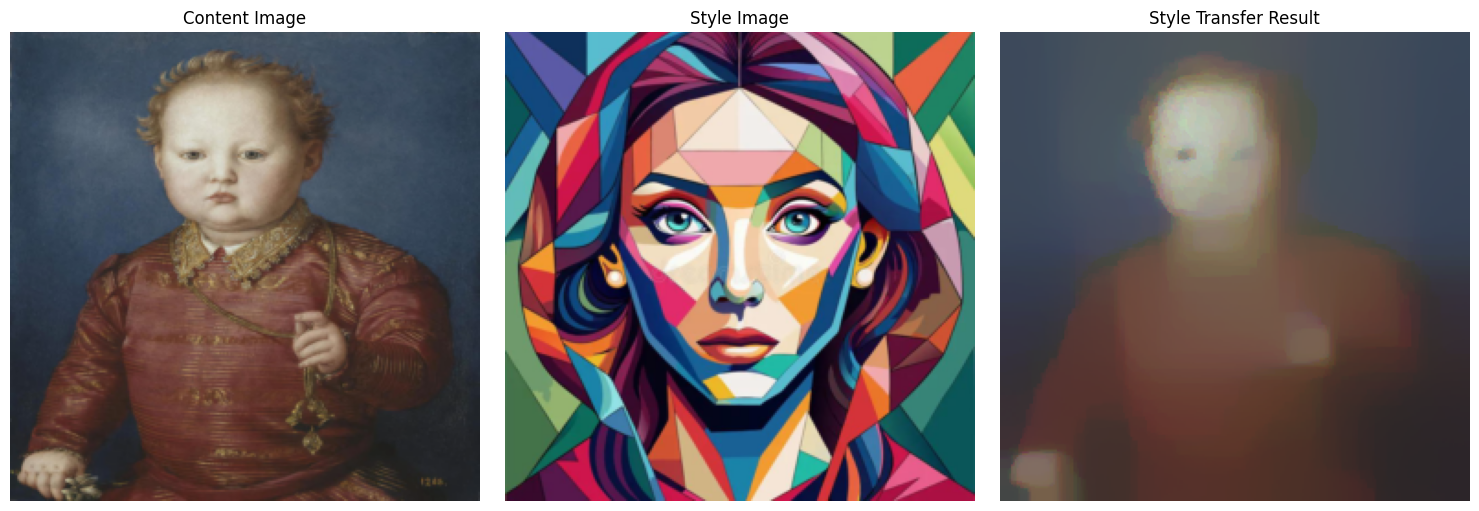

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# --------- Settings ---------
content_img_path = "E:/CV/content.jpg"
style_img_path = "E:/CV/style1.jpg"
output_img_path = "E:/CV/output_unet.jpg"
device = torch.device("cpu")
image_size = 256
num_steps = 800
tv_weight = 1e-4  # 增加TV权重以减少噪声
content_weight = 1.0
style_weight = 5e3  # 降低风格权重
feature_weight = 0.5  # 新增：浅层特征权重
color_weight = 0.3  # 新增：颜色一致性权重

# --------- Preprocessing ---------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet标准化
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def im_convert(tensor):
    image = tensor.clone().detach().squeeze(0)
    # 反标准化
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * std + mean
    image = image.clamp(0, 1)
    return transforms.ToPILImage()(image)

# --------- 改进的U-Net Style CNN ---------
class ImprovedUNetStyleTransfer(nn.Module):
    def __init__(self):
        super(ImprovedUNetStyleTransfer, self).__init__()
        
        # 编码器 - 更深层次的特征提取
        self.enc1 = self._conv_block(3, 32, 7)      # 更大卷积核保留细节
        self.enc2 = self._conv_block(32, 64, 3, stride=2)
        self.enc3 = self._conv_block(64, 128, 3, stride=2)
        self.enc4 = self._conv_block(128, 256, 3, stride=2)
        
        # 残差块 - 增加网络深度
        self.res_blocks = nn.Sequential(*[self._res_block(256) for _ in range(6)])
        
        # 解码器 - 对应的上采样
        self.dec1 = self._upconv_block(256, 128)
        self.dec2 = self._upconv_block(128 + 128, 64)  # skip connection
        self.dec3 = self._upconv_block(64 + 64, 32)    # skip connection
        
        # 输出层 - 改用更平滑的激活
        self.out_layer = nn.Sequential(
            nn.Conv2d(32 + 32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, padding=1),
            nn.Sigmoid()  # 改用Sigmoid确保输出在[0,1]范围
        )
        
        # 初始化权重
        self._initialize_weights()
    
    def _conv_block(self, in_ch, out_ch, kernel_size, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, 
                     padding=kernel_size//2),
            nn.BatchNorm2d(out_ch),  # 添加BN层稳定训练
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def _upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def _res_block(self, ch):
        return nn.Sequential(
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.BatchNorm2d(ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.BatchNorm2d(ch)
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 编码器
        e1 = self.enc1(x)        # [B, 32, H, W]
        e2 = self.enc2(e1)       # [B, 64, H/2, W/2]
        e3 = self.enc3(e2)       # [B, 128, H/4, W/4]
        e4 = self.enc4(e3)       # [B, 256, H/8, W/8]
        
        # 残差块
        r = e4
        for res_block in self.res_blocks:
            r = r + res_block(r)  # 残差连接
        
        # 解码器
        d1 = self.dec1(r)                      # [B, 128, H/4, W/4]
        d1_cat = torch.cat([d1, e3], dim=1)    # skip connection
        d2 = self.dec2(d1_cat)                 # [B, 64, H/2, W/2]
        d2_cat = torch.cat([d2, e2], dim=1)    # skip connection
        d3 = self.dec3(d2_cat)                 # [B, 32, H, W]
        d3_cat = torch.cat([d3, e1], dim=1)    # skip connection
        
        out = self.out_layer(d3_cat)
        
        return out, [e1, e2, e3, e4]  # 返回多层特征

# --------- 改进的Gram Matrix ---------
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)

# --------- 颜色直方图匹配损失 ---------
def color_histogram_loss(target, content):
    """计算颜色分布损失，保持内容图像的颜色特征"""
    target_hist = torch.histc(target.view(-1), bins=256, min=0, max=1)
    content_hist = torch.histc(content.view(-1), bins=256, min=0, max=1)
    target_hist = target_hist / target_hist.sum()
    content_hist = content_hist / content_hist.sum()
    return F.kl_div(target_hist.log(), content_hist, reduction='sum')

# --------- 感知损失（多层特征） ---------
def perceptual_loss(target_feats, content_feats, weights=[0.2, 0.3, 0.3, 0.2]):
    """多层感知损失，重点保护面部细节"""
    loss = 0
    for i, (tf, cf, w) in enumerate(zip(target_feats, content_feats, weights)):
        loss += w * F.mse_loss(tf, cf)
    return loss

# --------- Load & Extract ---------
net = ImprovedUNetStyleTransfer().to(device).train()  # 训练模式使用BN
content = load_image(content_img_path)
style = load_image(style_img_path)

# 初始化目标图像为内容图像（更好的起点）
target = content.clone().requires_grad_(True)

# 提取特征
with torch.no_grad():
    net.eval()
    _, content_feats = net(content)
    _, style_feats = net(style)
    net.train()
    
    # 预计算风格的Gram矩阵
    style_grams = [gram_matrix(f) for f in style_feats]

# --------- 优化器设置 ---------
optimizer = optim.Adam([target], lr=0.01, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.8)

print("开始风格迁移训练...")
for step in range(num_steps):
    optimizer.zero_grad()
    
    # 前向传播
    out_img, target_feats = net(target)
    
    # 1. 内容损失 - 主要使用深层特征
    content_loss = F.mse_loss(target_feats[-1], content_feats[-1])
    
    # 2. 感知损失 - 多层特征保护细节
    perceptual_loss_val = perceptual_loss(target_feats, content_feats)
    
    # 3. 风格损失 - 使用多层Gram矩阵
    style_loss = 0
    style_weights = [0.2, 0.3, 0.3, 0.2]  # 不同层的权重
    for tf, sg, sw in zip(target_feats, style_grams, style_weights):
        style_loss += sw * F.mse_loss(gram_matrix(tf), sg)
    
    # 4. 总变分损失 - 平滑化
    tv_h = torch.sum(torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:]))
    tv_w = torch.sum(torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :]))
    tv_loss = tv_h + tv_w
    
    # 5. 颜色一致性损失
    color_loss = color_histogram_loss(target, content)
    
    # 总损失
    total_loss = (content_weight * content_loss + 
                  feature_weight * perceptual_loss_val +
                  style_weight * style_loss + 
                  tv_weight * tv_loss +
                  color_weight * color_loss)
    
    total_loss.backward()
    
    # 梯度裁剪防止爆炸
    torch.nn.utils.clip_grad_norm_([target], max_norm=1.0)
    
    optimizer.step()
    scheduler.step()
    
    # 限制像素值范围
    with torch.no_grad():
        target.clamp_(-2.2, 2.2)  # 基于ImageNet标准化的合理范围
    
    if step % 100 == 0:
        print(f"Step {step}: Total={total_loss.item():.3f}, "
              f"Content={content_loss.item():.3f}, "
              f"Style={style_loss.item():.3f}, "
              f"Perceptual={perceptual_loss_val.item():.3f}")
        
        # 中间结果预览
        if step % 200 == 0:
            with torch.no_grad():
                preview = im_convert(target)
                preview.save(f"E:/CV/preview_step_{step}.jpg")

# --------- 后处理和保存 ---------
print("训练完成，保存结果...")
with torch.no_grad():
    final_output = im_convert(target)
    
    # 可选：轻微的颜色校正
    final_output.save(output_img_path)
    print(f"结果已保存到: {output_img_path}")
    
    # 显示结果对比
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(im_convert(content))
    axes[0].set_title('Content Image')
    axes[0].axis('off')
    
    axes[1].imshow(im_convert(style))
    axes[1].set_title('Style Image')
    axes[1].axis('off')
    
    axes[2].imshow(final_output)
    axes[2].set_title('Style Transfer Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig("E:/CV/comparison.jpg", dpi=150, bbox_inches='tight')
    plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# --------- 路径设置 ---------
content_img_path = "E:/CV/content.jpg"
style_img_path = "E:/CV/style1.jpg"
output_img_path = "E:/CV/output_unet.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 256

# --------- 数据预处理 ---------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device)

def save_image(tensor, path):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = transforms.ToPILImage()(image.clamp(0, 1))
    image.save(path)

# --------- 简单 Encoder-Decoder 模型（VAE） ---------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.deconv(x)

# --------- 风格迁移函数：交换风格内容特征 ---------
def style_transfer(content, style):
    content_feat = encoder(content)
    style_feat = encoder(style)
    
    # 简单融合 latent 特征：平均（也可以尝试加权、插值）
    mixed_feat = (content_feat + style_feat) / 2
    output = decoder(mixed_feat)
    return output

# --------- 主函数 ---------
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# 加载图像
content_image = load_image(content_img_path)
style_image = load_image(style_img_path)

# 风格迁移
with torch.no_grad():
    output_image = style_transfer(content_image, style_image)
    save_image(output_image, output_img_path)

print(f"风格迁移完成，图像已保存至 {output_img_path}")


风格迁移完成，图像已保存至 E:/CV/output_unet.jpg
